model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 372/372 [02:08<00:00,  2.89it/s]


Epoch 1/5 - Loss: 0.7983, Accuracy: 0.6887


100%|██████████| 372/372 [02:07<00:00,  2.91it/s]


Epoch 2/5 - Loss: 0.6638, Accuracy: 0.7572


100%|██████████| 372/372 [02:07<00:00,  2.91it/s]


Epoch 3/5 - Loss: 0.5948, Accuracy: 0.7975


100%|██████████| 372/372 [02:07<00:00,  2.91it/s]


Epoch 4/5 - Loss: 0.5603, Accuracy: 0.8035


100%|██████████| 372/372 [02:07<00:00,  2.91it/s]


Epoch 5/5 - Loss: 0.5329, Accuracy: 0.8086


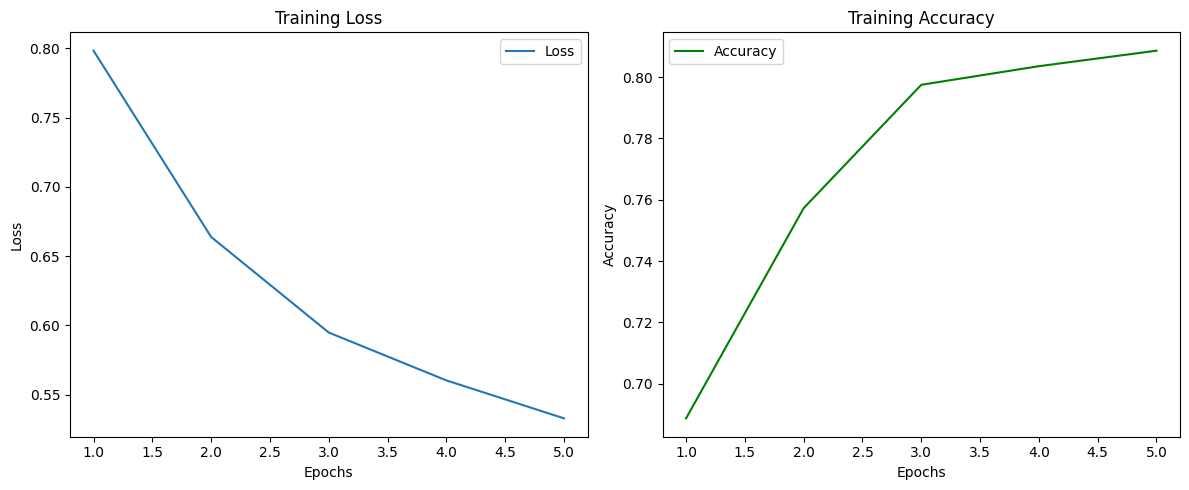

Classification Report:
              precision    recall  f1-score   support

          AC       0.71      0.61      0.66       340
          PC       0.62      0.52      0.56       165
          TC       0.00      0.00      0.00        24
          NC       0.84      0.93      0.88       957

    accuracy                           0.80      1486
   macro avg       0.54      0.51      0.53      1486
weighted avg       0.77      0.80      0.78      1486



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


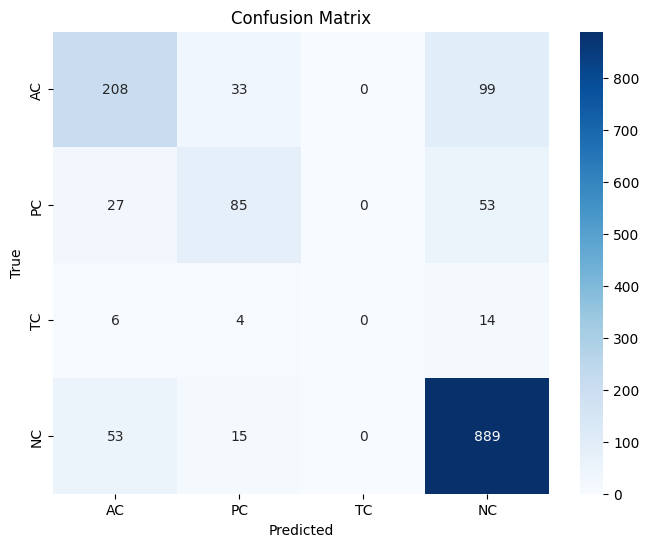

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-75d5fa83b9f6>:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We re

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd

# Load your DataFrame (assuming you already have it)
df = shuffled_df

# Define a mapping dictionary for categories to integers
category_mapping = {'AC': 0, 'PC': 1, 'TC': 2, 'NC': 3}
df['category_int'] = df['category'].map(category_mapping)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize text and encode labels
encoded_data = tokenizer(df['response'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')  # Adjust max_length if needed
labels = torch.tensor(df['category_int'].tolist())

# Train-Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(encoded_data['input_ids'],
                                                                     labels,
                                                                     test_size=0.2,
                                                                     random_state=42)

# Create DataLoader for training
train_dataset = TensorDataset(train_texts, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Create DataLoader for testing
test_dataset = TensorDataset(test_texts, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['category_int'].unique()))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function with class weights to handle class imbalance
class_counts = df['category_int'].value_counts()
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 5
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_preds = 0
    total_preds = 0

    for batch in tqdm(train_dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(input_ids=inputs, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        epoch_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(logits, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    avg_epoch_acc = correct_preds / total_preds
    train_losses.append(avg_epoch_loss)
    train_accuracies.append(avg_epoch_acc)

    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {avg_epoch_loss:.4f}, Accuracy: {avg_epoch_acc:.4f}")

# Plot Training Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation loop (optional)
model.eval()
test_preds = []
test_labels_list = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(input_ids=inputs)
        logits = outputs.logits

        _, predicted = torch.max(logits, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())

# Compute classification report and confusion matrix
print("Classification Report:")
print(classification_report(test_labels_list, test_preds, target_names=category_mapping.keys()))

# Confusion Matrix
cm = confusion_matrix(test_labels_list, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_mapping.keys(), yticklabels=category_mapping.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save the model to a file
torch.save(model.state_dict(), 'bert_model.pth')

# Load the model from the file
loaded_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['category_int'].unique()))
loaded_model.load_state_dict(torch.load('bert_model.pth'))
loaded_model.eval()  # Set the model to evaluation mode

# Example inference with loaded model
example_text = "I'm worried about time management and deadlines."
inputs = tokenizer(example_text, return_tensors="pt", truncation=True, padding=True, max_length=128)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = loaded_model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()

print(f"Predicted class for example: {predicted_class}")
print(f"Class probabilities: {probs.cpu().numpy()}")

